In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import pathlib
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import shutil
from tensorflow.keras import layers
from tensorflow.keras import regularizers

%matplotlib inline
print(tf.__version__)

2.2.0


In [2]:
#!pip install -q git+https://github.com/tensorflow/docs

In [3]:
#!pip install tables

Load fmri extracted raw time series from cerebellum atlas

In [19]:
seed = 2020
num_features = 28
ts_length = 158

logdir=pathlib.Path("./fmri")/"tensorboard_logs_fcnn"
shutil.rmtree(logdir, ignore_errors=False, onerror=None)


# origin h5 file location, load and shuffle timeseries
h5_file = '/data/elekin/data/results/00-EXTRACCION-CEREBELO/elekin_fmri_ts_pandas.hdf5'

tr_key = 'cbl/dataset'#transformed dataset (id,time series matrix 158x28, label)
dataset = pd.read_hdf(h5_file, tr_key)

num_samples = dataset.shape[0]
features = np.stack(dataset['features'].values).reshape(num_samples,ts_length*num_features)#from 2D to 1D
labels = dataset['label'].values.astype('int8')#load labels

features.shape, labels.shape

((101, 4424), (101,))

Data is already scaled from preprocessing. Since the dataset is prettry small Hold-out technique is used to evaluate the FCNN

In [5]:
np.random.seed(seed)
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size=0.33)

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((67, 4424), (67,), (34, 4424), (34,))

When training a model, it is often recommended to lower the learning rate as the training progresses. This schedule applies the inverse decay function to an optimizer step, given a provided initial learning rate. It requires a step value to compute the decayed learning rate. You can just pass a TensorFlow variable that you increment at each training step.

The schedule a 1-arg callable that produces a decayed learning rate when passed the current optimizer step. This can be useful for changing the learning rate value across different invocations of optimizer functions. It is computed as:
```python
def decayed_learning_rate(step):
  return initial_learning_rate / (1 + decay_rate * step / decay_step)
```

In [7]:
#https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay
STEPS_PER_EPOCH = 1
FEATURES = features.shape[1]

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

### Callbacks
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard
        

In [8]:
#Early stop configuration
earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.0001,
  patience=200)

training_earlystop_callback = EarlyStopping(
  monitor='accuracy', min_delta=0.0001,
  patience=200)

def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=300),
        tf.keras.callbacks.TensorBoard(logdir/name),
      ]

def compile_and_fit(model, name, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'binary_crossentropy'])
    model.summary()
    history = model.fit(X_train, y_train, batch_size=16, use_multiprocessing=True, 
                            validation_data=(X_test,y_test), epochs=max_epochs, callbacks=get_callbacks(name),
                            verbose=0)
    return history

In [9]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
tiny = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(FEATURES,)),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)])

In [10]:
size_histories = {}

In [20]:
size_histories['fcnn/tiny'] = compile_and_fit(tiny, "fmri/fcnn/tiny", optimizer=None, max_epochs=1000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                70800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 70,817
Trainable params: 70,817
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4179,  binary_crossentropy:0.7020,  loss:0.7020,  val_accuracy:0.4412,  val_binary_crossentropy:0.6978,  val_loss:0.6978,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0161,  loss:0.0161,  val_accuracy:0.6471,  val_binary_crossentropy:0.6458,  val_loss:0.6458,  
....................................................................................................
Epoch: 200, accurac

In [21]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
small_model = tf.keras.Sequential([
    # `input_shape` is only required here so that `.summary` works.
    tf.keras.layers.Dense(16, activation=tf.nn.relu, input_shape=(FEATURES,)),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
size_histories['fcnn/small'] = compile_and_fit(small_model, 'fmri/fcnn/small')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                70800     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 71,089
Trainable params: 71,089
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5970,  binary_crossentropy:0.6897,  loss:0.6897,  val_accuracy:0.3824,  val_binary_crossentropy:0.6968,  val_loss:0.6968,  
....................................................................................................
Epoch: 100, accuracy:1.0000,  binary_crossentropy:0.0027,  loss:0.0027,  val_accuracy:0.5882,  val_binary_crossentropy:0.7179,  val_los

In [22]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
large_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation=tf.nn.relu, input_shape=(FEATURES,)),    
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])
size_histories['fcnn/large'] = compile_and_fit(large_model, "fmri/fcnn/large")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2265600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 3,054,081
Trainable params: 3,054,081
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5821,  binary_crossentropy:0.6873,  loss:0.6873,  val_accuracy:0.4412,  val_binary_crossen

(0.0, 2.0)

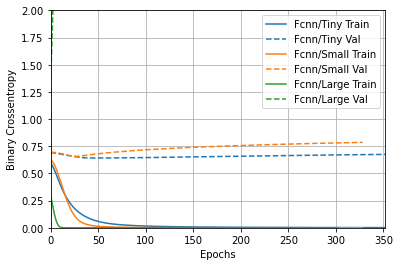

In [23]:
plotter_loss = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter_loss.plot(size_histories)
plt.ylim([0, 2.0])

(0.5, 1.05)

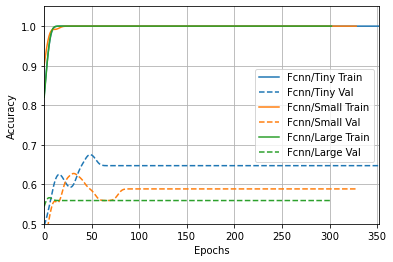

In [24]:
plotter_acc = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter_acc.plot(size_histories)
plt.ylim([0.5, 1.05])

Text(0.5, 0, 'Epochs [Log Scale]')

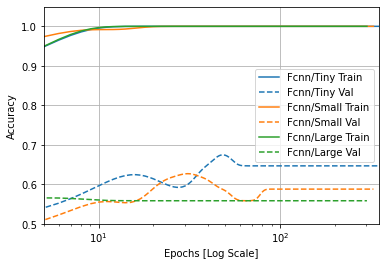

In [25]:
plotter_acc.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 1.05])
plt.xlabel("Epochs [Log Scale]")

Text(0.5, 0, 'Epochs [Log Scale]')

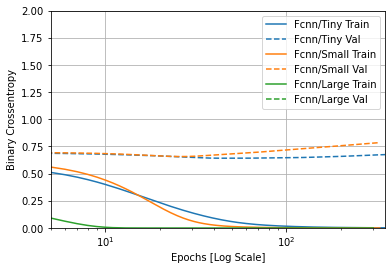

In [26]:
plotter_loss.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.0, 2.])
plt.xlabel("Epochs [Log Scale]")

In [27]:
shutil.rmtree(logdir/'regularizers/tiny', ignore_errors=True)
shutil.copytree(logdir/'fmri/fcnn/tiny', logdir/'regularizers/tiny')
regularizer_histories = {}
regularizer_histories['tiny'] = size_histories['fcnn/tiny']

In [28]:
lr = 8e-2
lr

0.08

In [29]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
l2_model = tf.keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr),
                 input_shape=(FEATURES,)),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dense(1, activation=tf.nn.sigmoid,kernel_regularizer=regularizers.l2(lr))
])

regularizer_histories['l2'] = compile_and_fit(l2_model, "regularizers/l2")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2265600   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 513       
Total params: 3,054,081
Trainable params: 3,054,081
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5224,  binary_crossentropy:0.6920,  loss:180.3074,  val_accuracy:0.4412,  val_binary_cross

(0.0, 1.0)

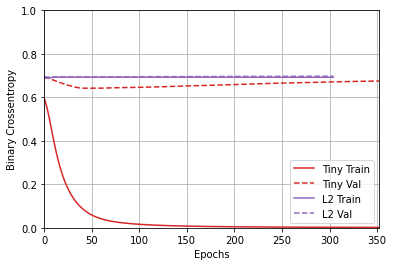

In [30]:
plotter_loss.plot(regularizer_histories)
plt.ylim([0., 1.])

(0.1, 1.05)

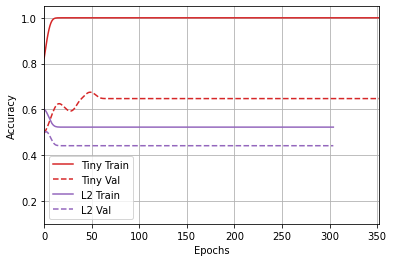

In [31]:
plotter_acc.plot(regularizer_histories)
plt.ylim([0.1, 1.05])

In [32]:
dr=0.3
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
drop_model = tf.keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu,
                 input_shape=(FEATURES,)),
    layers.Dropout(dr),results
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu),
    layers.Dropout(dr),
    layers.Dense(1, activation=tf.nn.sigmoid)
])

regularizer_histories['dropout'] = compile_and_fit(drop_model, "regularizers/dropout")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2265600   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

In [33]:
tf.keras.backend.clear_session()# para evitar que entrenamientos annteriores afecten
combined_model = tf.keras.Sequential([
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr),
                 input_shape=(FEATURES,)),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dropout(dr),
    layers.Dense(512, activation=tf.nn.relu,
                 kernel_regularizer=regularizers.l2(lr)),
    layers.Dropout(dr),
    layers.Dense(1, activation=tf.nn.sigmoid,
                 kernel_regularizer=regularizers.l2(lr))])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               2265600   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

(5.0, 352.0)

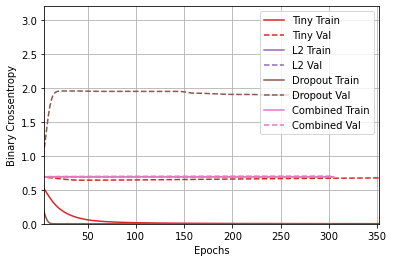

In [34]:
plotter_loss.plot(regularizer_histories)
plt.ylim([0., 3.2])
plt.xlim([5, max(plt.xlim())])

(0.4, 1.2)

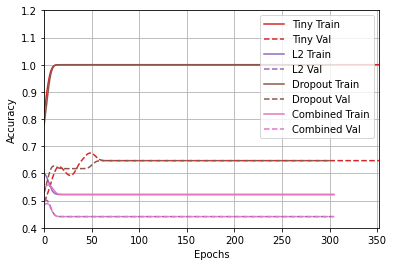

In [35]:
plotter_acc.plot(regularizer_histories)
plt.ylim([0.4, 1.2])